# Notebook 3: Predictive Model Training and Validation

**Project:** `PharmaControl-Pro`
**Goal:** Build, train, and validate the predictive 'ML kernel' that will power our MPC controller. This involves defining a sophisticated Transformer-based architecture, creating a custom loss function, and using a systematic approach for hyperparameter tuning.

### Table of Contents
1. [Model Architecture: A Transformer for Time-Series](#1.-Model-Architecture:-A-Transformer-for-Time-Series)
2. [Implementing a Custom Loss Function](#2.-Implementing-a-Custom-Loss-Function)
3. [Hyperparameter Tuning with Optuna](#3.-Hyperparameter-Tuning-with-Optuna)
4. [Training the Final Model](#4.-Training-the-Final-Model)
5. [Model Validation and Baseline Comparison](#5.-Model-Validation-and-Baseline-Comparison)

---
## 1. Model Architecture: A Transformer for Time-Series

The paper mentions a "Transformer-inspired" architecture. We will implement a robust **Encoder-Decoder** model using PyTorch's `nn.Transformer` components. This architecture is well-suited for sequence-to-sequence tasks like ours.

*   **Encoder:** Its job is to read the historical data (the last `L` steps of CMAs and CPPs) and compress this information into a rich, contextualized memory. It uses self-attention to understand the relationships within the historical sequence.
*   **Decoder:** Its job is to generate the future prediction. At each future time step `t` (from 1 to `H`), it looks at the entire encoded memory (via cross-attention) and combines that context with the *planned* control action for that future step (`future_U[t]`) to make a prediction. This structure explicitly models the relationship between future actions and future outcomes.

We will define this model in `src/model_architecture.py`.

--- 
## 2. Implementing a Custom Loss Function

The paper mentions a custom loss function designed to "prevent fitting irrelevant short-time dynamics." This implies that errors further out in the prediction horizon are more important than immediate, transient errors.

We can implement this by creating a **weighted Mean Squared Error (MSE)** loss. We'll assign a weight to each of the `H` steps in the horizon, with weights increasing over time. This forces the model to prioritize long-term accuracy.

In [17]:
import torch
import torch.nn as nn

class WeightedHorizonMSELoss(nn.Module):
    """Calculates MSE with a linearly increasing weight over the horizon."""
    def __init__(self, horizon: int, start_weight: float = 0.5, end_weight: float = 1.5):
        super().__init__()
        # Create a weight tensor of shape (1, horizon, 1) for broadcasting
        weights = torch.linspace(start_weight, end_weight, horizon).view(1, -1, 1)
        self.register_buffer('weights', weights)
        
    def forward(self, prediction, target):
        # prediction and target shape: (batch_size, horizon, features)
        loss = (prediction - target) ** 2
        weighted_loss = loss * self.weights
        return torch.mean(weighted_loss)

---
## 3. Hyperparameter Tuning with Optuna

Choosing the right hyperparameters (like learning rate, model size, etc.) is critical for performance. Manually guessing these values is inefficient. We will use **Optuna**, a powerful hyperparameter optimization framework, to systematically search for the best combination.

We'll define an `objective` function that takes a trial, builds a model with the suggested hyperparameters, trains it for a few epochs, and returns the validation loss. Optuna will then intelligently choose the next set of hyperparameters to try.

In [18]:
import optuna
import torch.optim as optim
import pandas as pd
import numpy as np
import os, sys
from sklearn.preprocessing import MinMaxScaler
import joblib

# Import our models and dataset
sys.path.append('..')  # Add parent directory to Python path
from V1.src.model_architecture import GranulationPredictor
from V1.src.dataset import GranulationDataset
from torch.utils.data import DataLoader

# --- Configuration Constants ---
# Data and model configuration
DATA_DIR = '../data'
LOOKBACK = 36                    # Historical context window (steps)
HORIZON = 72                     # Prediction horizon (steps)
CMA_COLS = ['d50', 'lod']       # Critical Material Attributes
CPP_COLS = ['spray_rate', 'air_flow', 'carousel_speed', 'specific_energy', 'froude_number_proxy']
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
RANDOM_SEED = 42                 # For reproducible results

# Hyperparameter tuning configuration
OPTUNA_CONFIG = {
    'n_trials': 800,             # Number of hyperparameter trials
    'tuning_epochs': 8,          # Epochs per trial (faster tuning)
    'tuning_batch_size': 128,    # Batch size for hyperparameter search
    'direction': 'minimize',     # Objective direction
    'timeout': 3600,             # 1 hour timeout
    'gc_after_trial': True       # Garbage collection # Minimize validation loss
}

# Final training configuration  
TRAINING_CONFIG = {
    'final_epochs': 50,          # Full training epochs
    'final_batch_size': 64,      # Production batch size
    'patience': 8,              # Early stopping patience
    'gradient_clip_value': 1.0,  # Gradient clipping threshold
    'min_delta': 1e-6           # Minimum improvement for early stopping
}

# Model architecture search space
MODEL_SEARCH_SPACE = {
    'd_model': [32, 64, 128],           # Transformer model dimensions
    'nhead': [2, 4, 8],                 # Number of attention heads
    'num_encoder_layers': (1, 4),       # Encoder layer range
    'num_decoder_layers': (1, 4),       # Decoder layer range
    'lr': (1e-5, 1e-2),                # Learning rate range (log scale)
    'dropout': (0.05, 0.15),            # Dropout probability range
    'weight_decay': (1e-6, 1e-3)       # L2 regularization range
}

# Loss function configuration
LOSS_CONFIG = {
    'horizon_weighting': True,          # Enable horizon-based weighting
    'start_weight': 0.5,               # Weight for early horizon steps
    'end_weight': 1.5,                 # Weight for late horizon steps
    'loss_type': 'mse'                 # Loss function type
}

# File paths
PATHS = {
    'model_save': os.path.join(DATA_DIR, 'best_predictor_model.pth'),
    'scalers_save': os.path.join(DATA_DIR, 'model_scalers.joblib'),
    'optuna_study': os.path.join(DATA_DIR, 'optuna_study.pkl'),
    'training_log': os.path.join(DATA_DIR, 'training_log.csv')
}

# Validation configuration
VALIDATION_CONFIG = {
    'eval_batch_size': 32,             # Batch size for evaluation
    'metrics': ['mae', 'rmse', 'mape'], # Evaluation metrics
    'save_predictions': True,           # Save test predictions
    'plot_samples': 3                  # Number of prediction plots
}

print(f"🔧 Configuration loaded:")
print(f"  Device: {DEVICE}")
print(f"  Data shape: {LOOKBACK} → {HORIZON} steps")
print(f"  Features: {len(CMA_COLS)} CMAs, {len(CPP_COLS)} CPPs")
print(f"  Hyperparameter trials: {OPTUNA_CONFIG['n_trials']}")
print(f"  Final training epochs: {TRAINING_CONFIG['final_epochs']}")

# Set random seeds for reproducibility
import torch
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

# --- Load Unscaled Data from Updated Pipeline ---
try:
    # Load raw unscaled data from notebook 02 pipeline
    df_train_raw = pd.read_csv(os.path.join(DATA_DIR, 'train_data_raw.csv'))
    df_val_raw = pd.read_csv(os.path.join(DATA_DIR, 'validation_data_raw.csv'))
    df_test_raw = pd.read_csv(os.path.join(DATA_DIR, 'test_data_raw.csv'))
    
    print(f"\n✓ Loaded unscaled datasets:")
    print(f"  Training: {df_train_raw.shape}")
    print(f"  Validation: {df_val_raw.shape}")
    print(f"  Test: {df_test_raw.shape}")
    
    # Validate all required columns exist
    all_required_cols = set(CMA_COLS + CPP_COLS)
    for name, df in [("train", df_train_raw), ("validation", df_val_raw), ("test", df_test_raw)]:
        missing_cols = all_required_cols - set(df.columns)
        if missing_cols:
            raise ValueError(f"{name} dataset missing required columns: {missing_cols}")
    
    print(f"✓ All datasets contain required columns: {len(all_required_cols)} features")
    
except Exception as e:
    raise RuntimeError(f"Failed to load datasets: {e}")

# --- Data Scaling for Model Training ---
def create_scalers_and_scale_data(df_train, df_val, df_test, feature_cols):
    """Create scalers fitted on training data and apply to all datasets.
    
    Args:
        df_train: Training dataframe (unscaled)
        df_val: Validation dataframe (unscaled)
        df_test: Test dataframe (unscaled)
        feature_cols: List of column names to scale
        
    Returns:
        Tuple of (scaled_train, scaled_val, scaled_test, scalers_dict)
    """
    scalers = {}
    
    # Create copies to avoid modifying original data
    df_train_scaled = df_train.copy()
    df_val_scaled = df_val.copy()
    df_test_scaled = df_test.copy()
    
    # Fit scalers on training data only and transform all datasets
    for col in feature_cols:
        scaler = MinMaxScaler()
        
        # Fit only on training data
        df_train_scaled[col] = scaler.fit_transform(df_train[[col]])
        
        # Transform validation and test data using fitted scaler
        df_val_scaled[col] = scaler.transform(df_val[[col]])
        df_test_scaled[col] = scaler.transform(df_test[[col]])
        
        scalers[col] = scaler
    
    return df_train_scaled, df_val_scaled, df_test_scaled, scalers

# Apply scaling
print(f"\n📊 Applying MinMax scaling to {len(CMA_COLS + CPP_COLS)} features...")
all_feature_cols = CMA_COLS + CPP_COLS
df_train, df_val, df_test, scalers = create_scalers_and_scale_data(
    df_train_raw, df_val_raw, df_test_raw, all_feature_cols
)

# Save scalers for later use (MPC controller, evaluation)
joblib.dump(scalers, PATHS['scalers_save'])
print(f"✓ Scalers saved to: {PATHS['scalers_save']}")

# Display scaling results
print(f"\n📈 Scaling Summary:")
for col in CMA_COLS + CPP_COLS[:3]:  # Show first few columns
    orig_min, orig_max = df_train_raw[col].min(), df_train_raw[col].max()
    scaled_min, scaled_max = df_train[col].min(), df_train[col].max()
    print(f"  {col}: [{orig_min:.2f}, {orig_max:.2f}] → [{scaled_min:.3f}, {scaled_max:.3f}]")

print(f"\n✅ Data preparation completed successfully!")

🔧 Configuration loaded:
  Device: cuda
  Data shape: 36 → 72 steps
  Features: 2 CMAs, 5 CPPs
  Hyperparameter trials: 800
  Final training epochs: 50

✓ Loaded unscaled datasets:
  Training: (10500, 7)
  Validation: (2250, 7)
  Test: (2250, 7)
✓ All datasets contain required columns: 7 features

📊 Applying MinMax scaling to 7 features...
✓ Scalers saved to: ../data/model_scalers.joblib

📈 Scaling Summary:
  d50: [291.17, 645.98] → [0.000, 1.000]
  lod: [0.50, 8.02] → [0.000, 1.000]
  spray_rate: [80.51, 179.65] → [0.000, 1.000]
  air_flow: [405.97, 698.82] → [0.000, 1.000]
  carousel_speed: [20.04, 39.73] → [0.000, 1.000]

✅ Data preparation completed successfully!


In [19]:
def objective(trial):
    """Optuna objective function for hyperparameter tuning with configurable parameters.
    
    Note: No try/except wrapper is used around this function. Optuna is designed to handle
    exceptions from individual trials gracefully and will report full tracebacks for 
    failed trials, which is essential for debugging hyperparameter search issues.
    """
    # --- Sample Hyperparameters from Search Space ---
    d_model = trial.suggest_categorical('d_model', MODEL_SEARCH_SPACE['d_model'])
    nhead = trial.suggest_categorical('nhead', MODEL_SEARCH_SPACE['nhead'])
    num_encoder_layers = trial.suggest_int('num_encoder_layers', 
                                         MODEL_SEARCH_SPACE['num_encoder_layers'][0],
                                         MODEL_SEARCH_SPACE['num_encoder_layers'][1])
    num_decoder_layers = trial.suggest_int('num_decoder_layers',
                                         MODEL_SEARCH_SPACE['num_decoder_layers'][0], 
                                         MODEL_SEARCH_SPACE['num_decoder_layers'][1])
    lr = trial.suggest_float('lr', 
                           MODEL_SEARCH_SPACE['lr'][0], 
                           MODEL_SEARCH_SPACE['lr'][1], log=True)
    dropout = trial.suggest_float('dropout',
                                MODEL_SEARCH_SPACE['dropout'][0],
                                MODEL_SEARCH_SPACE['dropout'][1])
    weight_decay = trial.suggest_float('weight_decay',
                                     MODEL_SEARCH_SPACE['weight_decay'][0],
                                     MODEL_SEARCH_SPACE['weight_decay'][1], log=True)
    
    # Validate nhead compatibility with d_model
    if d_model % nhead != 0:
        # Skip invalid combinations
        raise optuna.exceptions.TrialPruned()
    
    # --- Model, Loss, Optimizer ---
    model = GranulationPredictor(
        cma_features=len(CMA_COLS),
        cpp_features=len(CPP_COLS),
        d_model=d_model, 
        nhead=nhead,
        num_encoder_layers=num_encoder_layers,
        num_decoder_layers=num_decoder_layers,
        dropout=dropout
    ).to(DEVICE)
    
    criterion = WeightedHorizonMSELoss(
        horizon=HORIZON,
        start_weight=LOSS_CONFIG['start_weight'],
        end_weight=LOSS_CONFIG['end_weight']
    ).to(DEVICE)
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # --- DataLoaders with Configured Batch Size ---
    train_dataset = GranulationDataset(df_train, CMA_COLS, CPP_COLS, LOOKBACK, HORIZON)
    val_dataset = GranulationDataset(df_val, CMA_COLS, CPP_COLS, LOOKBACK, HORIZON)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=OPTUNA_CONFIG['tuning_batch_size'], 
        shuffle=True,
        num_workers=2
    )
    val_loader = DataLoader(
        val_dataset, 
        batch_size=OPTUNA_CONFIG['tuning_batch_size'], 
        shuffle=False,
        num_workers=2
    )

    # --- Training Loop with Configuration ---
    best_val_loss = float('inf')
    
    for epoch in range(OPTUNA_CONFIG['tuning_epochs']):
        model.train()
        epoch_loss = 0.0
        
        for batch_idx, batch in enumerate(train_loader):
            past_cmas, past_cpps, future_cpps, future_cmas_target = [b.to(DEVICE) for b in batch]
            
            optimizer.zero_grad()
            prediction = model(past_cmas, past_cpps, future_cpps)
            loss = criterion(prediction, future_cmas_target)
            loss.backward()
            
            # Apply gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), TRAINING_CONFIG['gradient_clip_value'])
            
            optimizer.step()
            epoch_loss += loss.item()
            
            # Report intermediate values for pruning
            if batch_idx % 10 == 0:
                trial.report(loss.item(), epoch * len(train_loader) + batch_idx)
                
                # Prune unpromising trials
                if trial.should_prune():
                    raise optuna.exceptions.TrialPruned()
        
        # Validation evaluation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                past_cmas, past_cpps, future_cpps, future_cmas_target = [b.to(DEVICE) for b in batch]
                prediction = model(past_cmas, past_cpps, future_cpps)
                val_loss += criterion(prediction, future_cmas_target).item()
        
        avg_val_loss = val_loss / len(val_loader)
        best_val_loss = min(best_val_loss, avg_val_loss)
        
        # Report for pruning
        trial.report(avg_val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return best_val_loss
    


In [20]:
# --- Run Configured Optuna Study ---
print(f"\n🔍 Starting hyperparameter optimization...")
print(f"  Trials: {OPTUNA_CONFIG['n_trials']}")
print(f"  Epochs per trial: {OPTUNA_CONFIG['tuning_epochs']}")
print(f"  Batch size: {OPTUNA_CONFIG['tuning_batch_size']}")

# Create study with pruning
study = optuna.create_study(
   # direction=OPTUNA_CONFIG['study_direction'],
    pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)
)

study.optimize(objective, n_trials=OPTUNA_CONFIG['n_trials'])

# Save study for later analysis
joblib.dump(study, PATHS['optuna_study'])

print(f"\n🎯 Hyperparameter optimization completed!")
print(f"Best trial found:")
best_trial = study.best_trial
print(f"  Validation Loss: {best_trial.value:.6f}")
print(f"  Parameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# Store best hyperparameters for final training
BEST_HPARAMS = best_trial.params

[I 2025-08-16 16:27:54,431] A new study created in memory with name: no-name-4690209d-52cc-41d7-895d-6008c87a3a16



🔍 Starting hyperparameter optimization...
  Trials: 800
  Epochs per trial: 8
  Batch size: 128


/home/tensor/PharmaControl/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
[I 2025-08-16 16:28:06,851] Trial 0 finished with value: 0.002294103539658382 and parameters: {'d_model': 32, 'nhead': 4, 'num_encoder_layers': 1, 'num_decoder_layers': 1, 'lr': 0.003995970573176855, 'dropout': 0.07695508786883604, 'weight_decay': 0.0005122079744190295}. Best is trial 0 with value: 0.002294103539658382.
/home/tensor/PharmaControl/.venv/lib/python3.12/site-packages/optuna/trial/_trial.py:501: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
[I 2025-08-16 16:28:36,725] Trial 1 finished with value: 0.0029117292108233363 and parameters: {'d_model': 128, 'nhead': 8, 'num_encoder_layers': 2, 'num_decoder_layers': 4, 'lr': 4.4001433385444076e-05, 'dropout': 0.09710785691557478, 'weight_decay': 0.000866296161649678}. Best is trial 0 w


🎯 Hyperparameter optimization completed!
Best trial found:
  Validation Loss: 0.000453
  Parameters:
    d_model: 128
    nhead: 8
    num_encoder_layers: 1
    num_decoder_layers: 1
    lr: 0.0009059439748286063
    dropout: 0.050044940567043526
    weight_decay: 1.6434038497210028e-06


---
## 4. Training the Final Model

Now that we have identified the optimal hyperparameters through Optuna, we'll train the final model using the complete training configuration with early stopping, learning rate scheduling, and comprehensive logging.

In [21]:
# --- Final Model Training with Configuration ---
from tqdm import tqdm
import copy
import csv
from datetime import datetime

print(f"\n🚀 Starting final model training with best hyperparameters...")
print(f"  Epochs: {TRAINING_CONFIG['final_epochs']}")
print(f"  Batch size: {TRAINING_CONFIG['final_batch_size']}")
print(f"  Early stopping patience: {TRAINING_CONFIG['patience']}")

# Create datasets and loaders with final configuration
train_dataset = GranulationDataset(df_train, CMA_COLS, CPP_COLS, LOOKBACK, HORIZON)
val_dataset = GranulationDataset(df_val, CMA_COLS, CPP_COLS, LOOKBACK, HORIZON)

train_loader = DataLoader(
    train_dataset, 
    batch_size=TRAINING_CONFIG['final_batch_size'], 
    shuffle=True,
    num_workers=4
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=TRAINING_CONFIG['final_batch_size'], 
    shuffle=False,
    num_workers=4
)

# Initialize final model with best hyperparameters
final_model = GranulationPredictor(
    cma_features=len(CMA_COLS),
    cpp_features=len(CPP_COLS),
    d_model=BEST_HPARAMS['d_model'], 
    nhead=BEST_HPARAMS['nhead'],
    num_encoder_layers=BEST_HPARAMS['num_encoder_layers'],
    num_decoder_layers=BEST_HPARAMS['num_decoder_layers'],
    dropout=BEST_HPARAMS['dropout']
).to(DEVICE)

# Loss function and optimizer with configuration
criterion = WeightedHorizonMSELoss(
    horizon=HORIZON,
    start_weight=LOSS_CONFIG['start_weight'],
    end_weight=LOSS_CONFIG['end_weight']
).to(DEVICE)

optimizer = optim.Adam(
    final_model.parameters(), 
    lr=BEST_HPARAMS['lr'],
    weight_decay=BEST_HPARAMS.get('weight_decay', 0.0)
)

# Learning rate scheduler (fixed verbose parameter)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5
)

# Training tracking
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_wts = copy.deepcopy(final_model.state_dict())
training_history = []

# Initialize training log
log_fields = ['epoch', 'train_loss', 'val_loss', 'lr', 'timestamp']
with open(PATHS['training_log'], 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(log_fields)

print(f"\n📊 Training progress:")

for epoch in range(TRAINING_CONFIG['final_epochs']):
    # Training phase
    final_model.train()
    train_loss = 0.0
    num_batches = 0
    
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TRAINING_CONFIG['final_epochs']}")
    
    for batch in pbar:
        past_cmas, past_cpps, future_cpps, future_cmas_target = [b.to(DEVICE) for b in batch]
        
        optimizer.zero_grad()
        prediction = final_model(past_cmas, past_cpps, future_cpps)
        loss = criterion(prediction, future_cmas_target)
        loss.backward()
        
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), TRAINING_CONFIG['gradient_clip_value'])
        
        optimizer.step()
        
        train_loss += loss.item()
        num_batches += 1
        
        pbar.set_postfix({
            'loss': f"{loss.item():.6f}",
            'avg_loss': f"{train_loss/num_batches:.6f}"
        })
    
    avg_train_loss = train_loss / num_batches
    
    # Validation phase
    final_model.eval()
    val_loss = 0.0
    val_batches = 0
    
    with torch.no_grad():
        for batch in val_loader:
            past_cmas, past_cpps, future_cpps, future_cmas_target = [b.to(DEVICE) for b in batch]
            prediction = final_model(past_cmas, past_cpps, future_cpps)
            val_loss += criterion(prediction, future_cmas_target).item()
            val_batches += 1
    
    avg_val_loss = val_loss / val_batches
    current_lr = optimizer.param_groups[0]['lr']
    
    # Learning rate scheduling
    old_lr = current_lr
    scheduler.step(avg_val_loss)
    new_lr = optimizer.param_groups[0]['lr']
    
    # Manual verbose output for learning rate changes
    if new_lr != old_lr:
        print(f"\n📉 Learning rate reduced: {old_lr:.2e} → {new_lr:.2e}")
    
    # Log training metrics
    timestamp = datetime.now().isoformat()
    training_history.append({
        'epoch': epoch + 1,
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
        'timestamp': timestamp
    })
    
    # Save to CSV log
    with open(PATHS['training_log'], 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([epoch + 1, avg_train_loss, avg_val_loss, current_lr, timestamp])
    
    print(f"Epoch {epoch+1:3d} | Train: {avg_train_loss:.6f} | Val: {avg_val_loss:.6f} | LR: {current_lr:.2e}")
    
    # Early stopping logic with configurable parameters
    if avg_val_loss < best_val_loss - TRAINING_CONFIG['min_delta']:
        best_val_loss = avg_val_loss
        best_model_wts = copy.deepcopy(final_model.state_dict())
        epochs_no_improve = 0
        print(f"    ✓ New best validation loss: {best_val_loss:.6f}")
    else:
        epochs_no_improve += 1
        print(f"    → No improvement for {epochs_no_improve} epochs")
    
    if epochs_no_improve >= TRAINING_CONFIG['patience']:
        print(f"\n🛑 Early stopping triggered after {epoch+1} epochs (patience: {TRAINING_CONFIG['patience']})")
        break

# Load best model weights and save
final_model.load_state_dict(best_model_wts)
torch.save({
    'model_state_dict': final_model.state_dict(),
    'hyperparameters': BEST_HPARAMS,
    'config': {
        'CMA_COLS': CMA_COLS,
        'CPP_COLS': CPP_COLS,
        'LOOKBACK': LOOKBACK,
        'HORIZON': HORIZON
    },
    'training_history': training_history,
    'best_val_loss': best_val_loss
}, PATHS['model_save'])

print(f"\n✅ Training completed successfully!")
print(f"  Best validation loss: {best_val_loss:.6f}")
print(f"  Model saved to: {PATHS['model_save']}")
print(f"  Training log saved to: {PATHS['training_log']}")


🚀 Starting final model training with best hyperparameters...
  Epochs: 50
  Batch size: 64
  Early stopping patience: 8

📊 Training progress:


Epoch 1/50: 100%|██████████| 163/163 [00:02<00:00, 56.06it/s, loss=0.003055, avg_loss=0.033704]


Epoch   1 | Train: 0.033704 | Val: 0.001405 | LR: 9.06e-04
    ✓ New best validation loss: 0.001405


Epoch 2/50: 100%|██████████| 163/163 [00:03<00:00, 50.90it/s, loss=0.001684, avg_loss=0.002241]


Epoch   2 | Train: 0.002241 | Val: 0.000797 | LR: 9.06e-04
    ✓ New best validation loss: 0.000797


Epoch 3/50: 100%|██████████| 163/163 [00:02<00:00, 54.71it/s, loss=0.001324, avg_loss=0.001507]


Epoch   3 | Train: 0.001507 | Val: 0.000689 | LR: 9.06e-04
    ✓ New best validation loss: 0.000689


Epoch 4/50: 100%|██████████| 163/163 [00:02<00:00, 54.82it/s, loss=0.001027, avg_loss=0.001202]


Epoch   4 | Train: 0.001202 | Val: 0.000535 | LR: 9.06e-04
    ✓ New best validation loss: 0.000535


Epoch 5/50: 100%|██████████| 163/163 [00:03<00:00, 53.19it/s, loss=0.000863, avg_loss=0.001011]


Epoch   5 | Train: 0.001011 | Val: 0.001315 | LR: 9.06e-04
    → No improvement for 1 epochs


Epoch 6/50: 100%|██████████| 163/163 [00:03<00:00, 53.77it/s, loss=0.000867, avg_loss=0.000908]


Epoch   6 | Train: 0.000908 | Val: 0.000713 | LR: 9.06e-04
    → No improvement for 2 epochs


Epoch 7/50: 100%|██████████| 163/163 [00:03<00:00, 54.18it/s, loss=0.000715, avg_loss=0.000845]


Epoch   7 | Train: 0.000845 | Val: 0.000604 | LR: 9.06e-04
    → No improvement for 3 epochs


Epoch 8/50: 100%|██████████| 163/163 [00:02<00:00, 55.54it/s, loss=0.000618, avg_loss=0.000726]


Epoch   8 | Train: 0.000726 | Val: 0.000454 | LR: 9.06e-04
    ✓ New best validation loss: 0.000454


Epoch 9/50: 100%|██████████| 163/163 [00:02<00:00, 54.61it/s, loss=0.000641, avg_loss=0.000675]


Epoch   9 | Train: 0.000675 | Val: 0.000438 | LR: 9.06e-04
    ✓ New best validation loss: 0.000438


Epoch 10/50: 100%|██████████| 163/163 [00:02<00:00, 55.98it/s, loss=0.000562, avg_loss=0.000653]


Epoch  10 | Train: 0.000653 | Val: 0.000356 | LR: 9.06e-04
    ✓ New best validation loss: 0.000356


Epoch 11/50: 100%|██████████| 163/163 [00:02<00:00, 55.47it/s, loss=0.000537, avg_loss=0.000565]


Epoch  11 | Train: 0.000565 | Val: 0.000379 | LR: 9.06e-04
    → No improvement for 1 epochs


Epoch 12/50: 100%|██████████| 163/163 [00:02<00:00, 56.68it/s, loss=0.000498, avg_loss=0.000558]


Epoch  12 | Train: 0.000558 | Val: 0.000531 | LR: 9.06e-04
    → No improvement for 2 epochs


Epoch 13/50: 100%|██████████| 163/163 [00:02<00:00, 55.53it/s, loss=0.000511, avg_loss=0.000503]


Epoch  13 | Train: 0.000503 | Val: 0.000376 | LR: 9.06e-04
    → No improvement for 3 epochs


Epoch 14/50: 100%|██████████| 163/163 [00:02<00:00, 58.32it/s, loss=0.000423, avg_loss=0.000486]


Epoch  14 | Train: 0.000486 | Val: 0.000428 | LR: 9.06e-04
    → No improvement for 4 epochs


Epoch 15/50: 100%|██████████| 163/163 [00:02<00:00, 57.15it/s, loss=0.000406, avg_loss=0.000490]


Epoch  15 | Train: 0.000490 | Val: 0.000315 | LR: 9.06e-04
    ✓ New best validation loss: 0.000315


Epoch 16/50: 100%|██████████| 163/163 [00:02<00:00, 58.93it/s, loss=0.000444, avg_loss=0.000449]


Epoch  16 | Train: 0.000449 | Val: 0.000382 | LR: 9.06e-04
    → No improvement for 1 epochs


Epoch 17/50: 100%|██████████| 163/163 [00:03<00:00, 46.58it/s, loss=0.000539, avg_loss=0.000480]


Epoch  17 | Train: 0.000480 | Val: 0.000393 | LR: 9.06e-04
    → No improvement for 2 epochs


Epoch 18/50: 100%|██████████| 163/163 [00:02<00:00, 58.12it/s, loss=0.000408, avg_loss=0.000435]


Epoch  18 | Train: 0.000435 | Val: 0.000467 | LR: 9.06e-04
    → No improvement for 3 epochs


Epoch 19/50: 100%|██████████| 163/163 [00:03<00:00, 53.76it/s, loss=0.000408, avg_loss=0.000420]


Epoch  19 | Train: 0.000420 | Val: 0.000333 | LR: 9.06e-04
    → No improvement for 4 epochs


Epoch 20/50: 100%|██████████| 163/163 [00:03<00:00, 50.26it/s, loss=0.000513, avg_loss=0.000422]


Epoch  20 | Train: 0.000422 | Val: 0.000475 | LR: 9.06e-04
    → No improvement for 5 epochs


Epoch 21/50: 100%|██████████| 163/163 [00:02<00:00, 56.71it/s, loss=0.000388, avg_loss=0.000421]



📉 Learning rate reduced: 9.06e-04 → 4.53e-04
Epoch  21 | Train: 0.000421 | Val: 0.000609 | LR: 9.06e-04
    → No improvement for 6 epochs


Epoch 22/50: 100%|██████████| 163/163 [00:03<00:00, 52.11it/s, loss=0.000370, avg_loss=0.000370]


Epoch  22 | Train: 0.000370 | Val: 0.000360 | LR: 4.53e-04
    → No improvement for 7 epochs


Epoch 23/50: 100%|██████████| 163/163 [00:02<00:00, 56.66it/s, loss=0.000394, avg_loss=0.000362]


Epoch  23 | Train: 0.000362 | Val: 0.000344 | LR: 4.53e-04
    → No improvement for 8 epochs

🛑 Early stopping triggered after 23 epochs (patience: 8)

✅ Training completed successfully!
  Best validation loss: 0.000315
  Model saved to: ../data/best_predictor_model.pth
  Training log saved to: ../data/training_log.csv


---
## 5. Model Validation and Baseline Comparison

With the trained model, we'll perform comprehensive evaluation including multiple metrics, visualization of predictions, and error analysis to validate the model's performance for MPC deployment.

🧪 Evaluating final model on test set...
🔄 Running inference on test set...
  Processed 1/67 batches
  Processed 11/67 batches
  Processed 21/67 batches
  Processed 31/67 batches
  Processed 41/67 batches
  Processed 51/67 batches
  Processed 61/67 batches
✓ Processed 2143 test samples
🔄 Converting predictions back to original scale...
📊 Calculating performance metrics...

🎯 COMPREHENSIVE TEST SET RESULTS
Test Samples: 2,143
Prediction Horizon: 72 steps
Model Architecture: 128-dim transformer
Best Validation Loss: 0.000315

📈 Performance Metrics (Original Scale):
----------------------------------------

D50 (μm):
  MAE:  6.312 μm
  RMSE: 8.430 μm
  MAPE: 1.4%
  R²:   0.990
  Dir.Acc: 57.2%

LOD (%):
  MAE:  0.339 %
  RMSE: 0.382 %
  MAPE: 3.8%
  R²:   0.723
  Dir.Acc: 55.7%

📊 Creating visualizations...


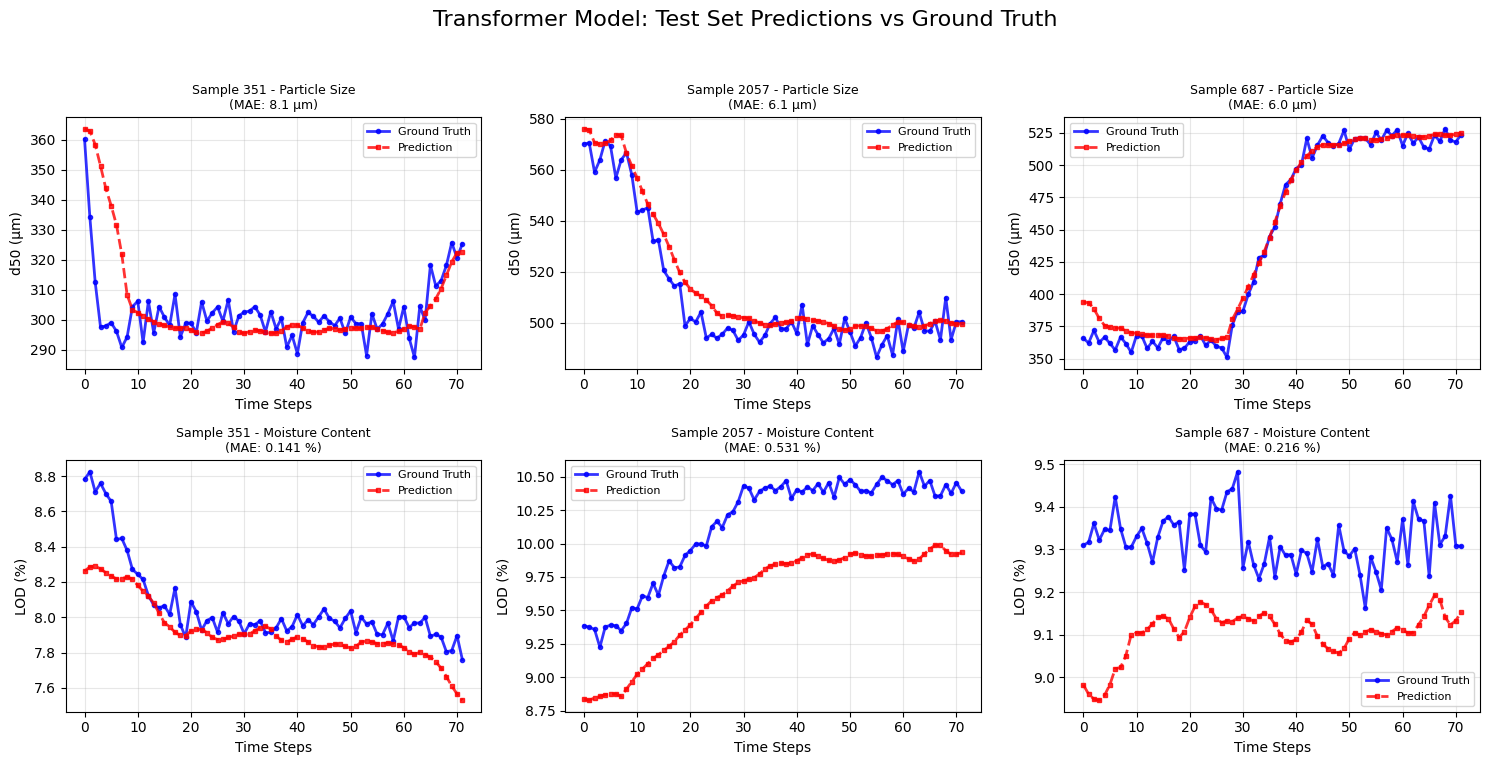

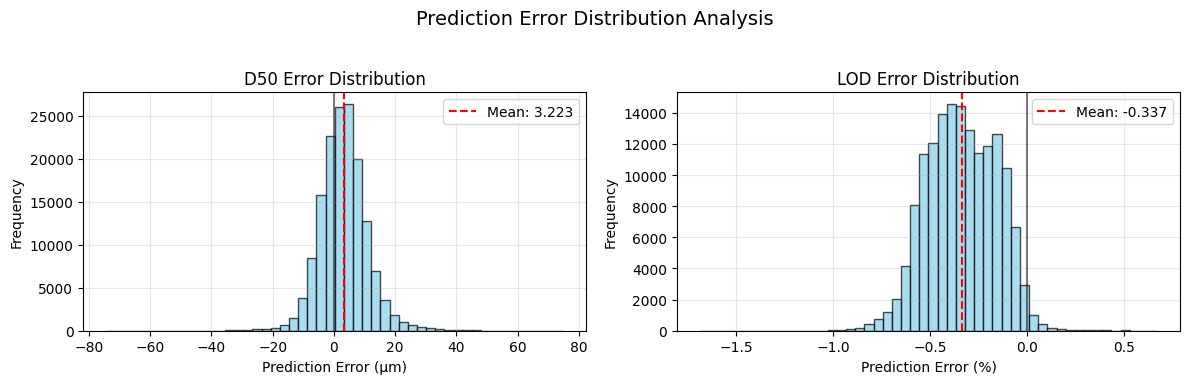

💾 Test predictions saved to: ../data/test_predictions.npz

✅ Model evaluation completed successfully!


In [22]:
import matplotlib.pyplot as plt
import numpy as np

# --- Enhanced Model Evaluation with Multiple Metrics ---
print("🧪 Evaluating final model on test set...")

# Create test dataset and loader
test_dataset = GranulationDataset(df_test, CMA_COLS, CPP_COLS, LOOKBACK, HORIZON)
test_loader = DataLoader(
    test_dataset, 
    batch_size=VALIDATION_CONFIG['eval_batch_size'], 
    shuffle=False,
    num_workers=2
)

def calculate_metrics(predictions, targets, feature_names):
    """Calculate comprehensive evaluation metrics."""
    metrics = {}
    
    for i, feature in enumerate(feature_names):
        pred_feature = predictions[:, :, i].flatten()
        target_feature = targets[:, :, i].flatten()
        
        # Mean Absolute Error
        mae = np.mean(np.abs(pred_feature - target_feature))
        
        # Root Mean Square Error
        rmse = np.sqrt(np.mean((pred_feature - target_feature)**2))
        
        # Mean Absolute Percentage Error
        mape = np.mean(np.abs((target_feature - pred_feature) / (target_feature + 1e-8))) * 100
        
        # R-squared
        ss_res = np.sum((target_feature - pred_feature)**2)
        ss_tot = np.sum((target_feature - np.mean(target_feature))**2)
        r2 = 1 - (ss_res / (ss_tot + 1e-8))
        
        # Directional accuracy (for time series)
        target_diff = np.diff(target_feature)
        pred_diff = np.diff(pred_feature)
        directional_accuracy = np.mean(np.sign(target_diff) == np.sign(pred_diff)) * 100
        
        metrics[feature] = {
            'MAE': mae,
            'RMSE': rmse, 
            'MAPE': mape,
            'R2': r2,
            'Directional_Accuracy': directional_accuracy
        }
    
    return metrics

# --- Full Test Set Evaluation ---
final_model.eval()
all_predictions_scaled = []
all_targets_scaled = []

print("🔄 Running inference on test set...")
with torch.no_grad():
    for batch_idx, batch in enumerate(test_loader):
        past_cmas, past_cpps, future_cpps, future_cmas_target = [b.to(DEVICE) for b in batch]
        
        # Get predictions (scaled)
        predictions = final_model(past_cmas, past_cpps, future_cpps)
        
        all_predictions_scaled.append(predictions.cpu().numpy())
        all_targets_scaled.append(future_cmas_target.cpu().numpy())
        
        if batch_idx % 10 == 0:
            print(f"  Processed {batch_idx+1}/{len(test_loader)} batches")

# Concatenate all predictions and targets
all_predictions_scaled = np.concatenate(all_predictions_scaled, axis=0)
all_targets_scaled = np.concatenate(all_targets_scaled, axis=0)

print(f"✓ Processed {all_predictions_scaled.shape[0]} test samples")

# --- Convert to Original Scale ---
print("🔄 Converting predictions back to original scale...")
all_predictions_unscaled = np.zeros_like(all_predictions_scaled)
all_targets_unscaled = np.zeros_like(all_targets_scaled)

for i, col in enumerate(CMA_COLS):
    # Reshape for scaler (expects 2D)
    pred_reshaped = all_predictions_scaled[:, :, i].reshape(-1, 1)
    target_reshaped = all_targets_scaled[:, :, i].reshape(-1, 1)
    
    # Inverse transform
    pred_orig = scalers[col].inverse_transform(pred_reshaped)
    target_orig = scalers[col].inverse_transform(target_reshaped)
    
    # Reshape back to original shape
    all_predictions_unscaled[:, :, i] = pred_orig.reshape(all_predictions_scaled.shape[0], -1)
    all_targets_unscaled[:, :, i] = target_orig.reshape(all_targets_scaled.shape[0], -1)

# --- Calculate Comprehensive Metrics ---
print("📊 Calculating performance metrics...")
metrics_scaled = calculate_metrics(all_predictions_scaled, all_targets_scaled, CMA_COLS)
metrics_unscaled = calculate_metrics(all_predictions_unscaled, all_targets_unscaled, CMA_COLS)

# --- Display Results ---
print(f"\n🎯 COMPREHENSIVE TEST SET RESULTS")
print("=" * 60)
print(f"Test Samples: {all_predictions_unscaled.shape[0]:,}")
print(f"Prediction Horizon: {HORIZON} steps")
print(f"Model Architecture: {BEST_HPARAMS['d_model']}-dim transformer")
print(f"Best Validation Loss: {best_val_loss:.6f}")

print(f"\n📈 Performance Metrics (Original Scale):")
print("-" * 40)
for feature in CMA_COLS:
    m = metrics_unscaled[feature]
    unit = "μm" if feature == "d50" else "%"
    print(f"\n{feature.upper()} ({unit}):")
    print(f"  MAE:  {m['MAE']:.3f} {unit}")
    print(f"  RMSE: {m['RMSE']:.3f} {unit}")
    print(f"  MAPE: {m['MAPE']:.1f}%")
    print(f"  R²:   {m['R2']:.3f}")
    print(f"  Dir.Acc: {m['Directional_Accuracy']:.1f}%")

# --- Visualization ---
print(f"\n📊 Creating visualizations...")

# Plot multiple sample predictions
num_samples = min(VALIDATION_CONFIG['plot_samples'], all_predictions_unscaled.shape[0])
sample_indices = np.random.choice(all_predictions_unscaled.shape[0], num_samples, replace=False)

fig, axes = plt.subplots(len(CMA_COLS), num_samples, figsize=(5*num_samples, 4*len(CMA_COLS)))
if len(CMA_COLS) == 1:
    axes = axes.reshape(1, -1)
if num_samples == 1:
    axes = axes.reshape(-1, 1)

fig.suptitle('Transformer Model: Test Set Predictions vs Ground Truth', fontsize=16)

for col_idx, col in enumerate(CMA_COLS):
    for sample_idx in range(num_samples):
        ax = axes[col_idx, sample_idx]
        
        sample_id = sample_indices[sample_idx]
        time_steps = range(HORIZON)
        
        target = all_targets_unscaled[sample_id, :, col_idx]
        prediction = all_predictions_unscaled[sample_id, :, col_idx]
        
        ax.plot(time_steps, target, 'b-', linewidth=2, marker='o', markersize=3, 
                label='Ground Truth', alpha=0.8)
        ax.plot(time_steps, prediction, 'r--', linewidth=2, marker='s', markersize=3,
                label='Prediction', alpha=0.8)
        
        # Calculate sample-specific metrics
        sample_mae = np.mean(np.abs(prediction - target))
        
        if col == 'd50':
            ax.set_ylabel('d50 (μm)', fontsize=10)
            ax.set_title(f'Sample {sample_id+1} - Particle Size\n(MAE: {sample_mae:.1f} μm)', fontsize=9)
        elif col == 'lod':
            ax.set_ylabel('LOD (%)', fontsize=10)
            ax.set_title(f'Sample {sample_id+1} - Moisture Content\n(MAE: {sample_mae:.3f} %)', fontsize=9)
        
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Time Steps', fontsize=10)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Error Distribution Analysis ---
fig, axes = plt.subplots(1, len(CMA_COLS), figsize=(6*len(CMA_COLS), 4))
if len(CMA_COLS) == 1:
    axes = [axes]

fig.suptitle('Prediction Error Distribution Analysis', fontsize=14)

for i, col in enumerate(CMA_COLS):
    errors = (all_predictions_unscaled[:, :, i] - all_targets_unscaled[:, :, i]).flatten()
    
    axes[i].hist(errors, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].axvline(np.mean(errors), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(errors):.3f}')
    axes[i].axvline(0, color='black', linestyle='-', alpha=0.5)
    
    unit = "μm" if col == "d50" else "%"
    axes[i].set_xlabel(f'Prediction Error ({unit})', fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].set_title(f'{col.upper()} Error Distribution', fontsize=12)
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# --- Save Results ---
if VALIDATION_CONFIG['save_predictions']:
    results_file = os.path.join(DATA_DIR, 'test_predictions.npz')
    np.savez(results_file,
             predictions=all_predictions_unscaled,
             targets=all_targets_unscaled,
             metrics=metrics_unscaled,
             config=BEST_HPARAMS)
    print(f"💾 Test predictions saved to: {results_file}")

print(f"\n✅ Model evaluation completed successfully!")